In [1]:
import sys
import matplotlib.pyplot as plt

import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer import Trace_ELBO


sys.path.append("../sbo")

import sbo
from sbo import TargetFunction

## Target function

In [2]:
class HyperbolicTarget(sbo.TargetFunction):
    
    def eval(self, x):
        
        x1 = x[...,0]
        x2 = x[...,1]

        return 0.3*x1**2 + 2*x2**2 

target = HyperbolicTarget([[-10, 10], [-10, 10]])

## Training data

In [3]:
sbo.set_random_seed(111)

In [4]:
N_train_points = 3
X_train = torch.rand(N_train_points, 2)*20 + torch.FloatTensor([-10, -10])
y_train = target.eval(X_train)

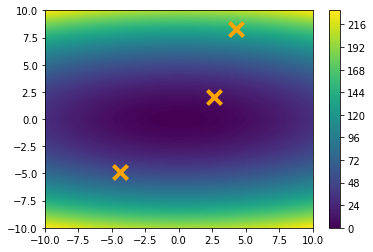

In [5]:
sbo.plot2D_obj(target.eval, target.ranges)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

## Parametric model

In [6]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 10))
        
    def forward(self, X):

        x1 = X[...,0]
        x2 = X[...,1]
        
        return self.alpha * x2**2

## SBO

In [7]:
pyro.clear_param_store()

# SBO parameters
opti_num_steps = 1000
opti_params = {"lr": 0.1}
optimizer = pyro.optim.Adam(opti_params)
loss = Trace_ELBO()

num_candidates = 5

# Sampling
num_samples = 1

In [8]:
# GP kernel
kernel = gp.kernels.Matern52(
    input_dim = X_train.shape[1], lengthscale = 10*torch.ones(X_train.shape[1]))

# Semi paramteric GP model
semi_model = sbo.SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

# Defining GP's parameters
semi_model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([X_train.shape[1]]).to_event())
semi_model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
semi_model.gp.noise = PyroSample(dist.Uniform(0, 1))

In [9]:
losses, semi_model_guide = sbo.train(semi_model, optimizer, loss, num_steps=opti_num_steps)

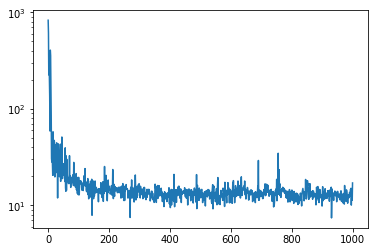

In [10]:
plt.semilogy(losses);

In [16]:
import sbo
from sbo import TargetFunction

In [17]:
def step(semi_model, semi_model_guide, target, num_samples=1, num_candidates=5, return_site='EI'):
    
    # Constructs predictive distribution
    model_predict = pyro.infer.Predictive(semi_model, guide=semi_model_guide, 
                                          num_samples=num_samples, return_sites=(return_site, ))
    
#     plt.figure(figsize=(15, 3)) 
#     for i in range(3):
#         with torch.no_grad():
#             plt.subplot(1,3,i+1)
#             plt.title("Test %d" % (i))
#             sbo.plot2D_obj(lambda x: model_predict(x)[return_site].mean(0), target.ranges)
    
    
    # Finds next candidate 
    x_new = sbo.next_x(model_predict, return_site, target, 
                       num_candidates=num_candidates, 
                       num_steps=1000, 
                       num_samples=num_samples)
    
    print(x_new)

In [18]:
step(semi_model, semi_model_guide, target)

closure:  <function find_a_candidate.<locals>.closure at 0x12496d680>
y:  tensor([0.], grad_fn=<MeanBackward1>)
closure:  <function find_a_candidate.<locals>.closure at 0x12496d5f0>
y:  tensor([-12.7834], grad_fn=<MeanBackward1>)
closure:  <function find_a_candidate.<locals>.closure at 0x12496d680>
y:  tensor([-11.3524], grad_fn=<MeanBackward1>)
closure:  <function find_a_candidate.<locals>.closure at 0x12496d5f0>
y:  tensor([-6.2195], grad_fn=<MeanBackward1>)
closure:  <function find_a_candidate.<locals>.closure at 0x12496d680>
y:  tensor([-19.1012], grad_fn=<MeanBackward1>)
tensor([[-9.8832,  0.4298]])
